# CIFAR-10 Classifier w/PyTorch

## Load dataset

In [73]:
import torch
import torchvision
import torchvision.transforms as transforms

In [74]:
# Create transforms to preprocess data
# Convert to tensor then normalize to between -1 and 1 defining mean and std in each 3 image channels (rgb) 
# respectively
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load training data into PyTorch DataLoader which automatically creates batches of given size over dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

# Load testing data in same fashion
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

# Define class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


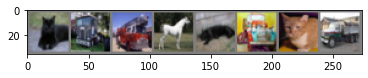

  cat truck truck horse   cat truck   cat truck


In [75]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

## Create Network

In [79]:
import torch.nn as nn
import torch.nn.functional as F

# Create custom neural net from base Module class, defining layers in __init__()
# Define activation/forward passes in forward()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.bnorm2 = nn.BatchNorm2d(32)
        self.bnorm3 = nn.BatchNorm2d(64)
        self.dropout1d = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.bnorm32(self.pool(F.relu(self.conv1(x)))) # Shape (batch_size, 16, 16, 16)
        x = self.bnorm1(self.pool(F.relu(self.conv2(x)))) # Shape (batch_size, 16, 8, 8)
        x = self.bnorm32(F.relu(self.conv3(x))) # Shape (batch_size, 32, 8, 8)
        x = self.bnorm3(self.pool(F.relu(self.conv4(x)))) # Shape (batch_size, 64, 4, 4)
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout1d(F.relu(self.fc1(x)))
        x = self.dropout1d(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Instantiate Net() class
net = Net()

In [80]:
import torch.optim as optim
# Define cross entropy as the loss function and Stochastic Gradient Descent for optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Train network

In [81]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.594
[1,  4000] loss: 1.324
[1,  6000] loss: 1.198
[2,  2000] loss: 1.049
[2,  4000] loss: 1.009
[2,  6000] loss: 0.977
[3,  2000] loss: 0.833
[3,  4000] loss: 0.832
[3,  6000] loss: 0.848
[4,  2000] loss: 0.702
[4,  4000] loss: 0.710
[4,  6000] loss: 0.727
[5,  2000] loss: 0.584
[5,  4000] loss: 0.618
[5,  6000] loss: 0.628
[6,  2000] loss: 0.498
[6,  4000] loss: 0.536
[6,  6000] loss: 0.564
[7,  2000] loss: 0.418
[7,  4000] loss: 0.476
[7,  6000] loss: 0.485
[8,  2000] loss: 0.385
[8,  4000] loss: 0.400
[8,  6000] loss: 0.428
[9,  2000] loss: 0.331
[9,  4000] loss: 0.358
[9,  6000] loss: 0.384
[10,  2000] loss: 0.297
[10,  4000] loss: 0.321
[10,  6000] loss: 0.368
Finished Training


In [89]:
# Save trained model to working directory
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the network

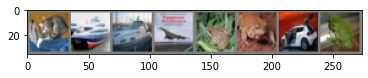

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


In [83]:
# Iterate over test data and show samples
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [84]:
# Intantiate new Net() object and load the saved state
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [85]:
# Pass 4 test images through trained model
outputs = net(images)

In [86]:
# Get and print predictions
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

Predicted:   frog   car  ship plane  deer  frog   car  frog


In [87]:
# Test on full test dataset and keep track of accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 72 %


In [88]:
# Test on full test dataset and get accuracy of each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 77 %
Accuracy of   car : 79 %
Accuracy of  bird : 65 %
Accuracy of   cat : 54 %
Accuracy of  deer : 65 %
Accuracy of   dog : 58 %
Accuracy of  frog : 80 %
Accuracy of horse : 80 %
Accuracy of  ship : 81 %
Accuracy of truck : 81 %
